# Compas Analysis

What follows are the calculations performed for ProPublica's analaysis of the COMPAS Recidivism Risk Scores. It might be helpful to open [the methodology](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm/) in another tab to understand the following.

## Loading the Data

We select fields for severity of charge, number of priors, demographics, age, sex, compas scores, and whether each person was accused of a crime within two years.

In [1]:
# filter dplyr warnings
%load_ext rpy2.ipython
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Nothing in Python

In [3]:
%%R
library(dplyr)
library(ggplot2)
raw_data <- read.csv("./compas-scores-two-years.csv")
nrow(raw_data)

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




[1] 7214


In [4]:
import pandas as pd

df = pd.read_csv("./compas-scores-two-years.csv", parse_dates=['c_jail_in', 'c_jail_out'])
df.info(verbose=False)
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7214 entries, 0 to 7213
Columns: 53 entries, id to two_year_recid
dtypes: datetime64[ns](2), float64(4), int64(16), object(31)
memory usage: 2.9+ MB


(7214, 53)

In [5]:
# Test cell
# list(df)
# df['c_jail_in'].dtypes

However not all of the rows are useable for the first round of analysis.

There are a number of reasons remove rows because of missing data:
* If the charge date of a defendants Compas scored crime was not within 30 days from when the person was arrested, we assume that because of data quality reasons, that we do not have the right offense.
* We coded the recidivist flag -- `is_recid` -- to be -1 if we could not find a compas case at all.
* In a similar vein, ordinary traffic offenses -- those with a `c_charge_degree` of 'O' -- will not result in Jail time are removed (only two of them).
* We filtered the underlying data from Broward county to include only those rows representing people who had either recidivated in two years, or had at least two years outside of a correctional facility.

In [6]:
%%R
df <- dplyr::select(raw_data, age, c_charge_degree, race, age_cat, score_text, sex, priors_count, 
                    days_b_screening_arrest, decile_score, is_recid, two_year_recid, c_jail_in, c_jail_out) %>% 
        filter(days_b_screening_arrest <= 30) %>%
        filter(days_b_screening_arrest >= -30) %>%
        filter(is_recid != -1) %>%
        filter(c_charge_degree != "O") %>%
        filter(score_text != 'N/A')
nrow(df)

[1] 6172


In [7]:
df = df[ 
    (df["days_b_screening_arrest"] <= 30) &
    (df["days_b_screening_arrest"] >= -30) &
    (df['c_charge_degree'] != "O") & 
    (df["is_recid"] != -1) &
    (df['score_text'] != 'N/A') # filters out none
]
df.shape[0]

6172

Higher COMPAS scores are slightly correlated with a longer length of stay. 

In [8]:
%%R
df$length_of_stay <- as.numeric(as.Date(df$c_jail_out) - as.Date(df$c_jail_in))
cor(df$length_of_stay, df$decile_score)

[1] 0.2073297


In [9]:
df["length_of_stay"] = df["c_jail_out"] - df["c_jail_in"]
pd.to_numeric(df["length_of_stay"]).corr(df["decile_score"]) # This number is a little different from R. probably the "to_numeric" function for dates is a little different 

0.20741201943031637

After filtering we have the following demographic breakdown:

In [10]:
%%R
summary(df$age_cat)

        25 - 45 Greater than 45    Less than 25 
           3532            1293            1347 


In [11]:
df["age_cat"].value_counts()

25 - 45            3532
Less than 25       1347
Greater than 45    1293
Name: age_cat, dtype: int64

In [12]:
%%R
summary(df$race)

African-American            Asian        Caucasian         Hispanic 
            3175               31             2103              509 
 Native American            Other 
              11              343 


In [13]:
df["race"].value_counts()

African-American    3175
Caucasian           2103
Hispanic             509
Other                343
Asian                 31
Native American       11
Name: race, dtype: int64

In [14]:
print("Black defendants: %.2f%%" %            (3175 / 6172 * 100))
print("White defendants: %.2f%%" %            (2103 / 6172 * 100))
print("Hispanic defendants: %.2f%%" %         (509  / 6172 * 100))
print("Asian defendants: %.2f%%" %            (31   / 6172 * 100))
print("Native American defendants: %.2f%%" %  (11   / 6172 * 100))

Black defendants: 51.44%
White defendants: 34.07%
Hispanic defendants: 8.25%
Asian defendants: 0.50%
Native American defendants: 0.18%


In [15]:
df["race"].value_counts() / df["race"].count() * 100

African-American    51.441996
Caucasian           34.073234
Hispanic             8.246922
Other                5.557356
Asian                0.502268
Native American      0.178224
Name: race, dtype: float64

In [16]:
%%R
summary(df$score_text)

  High    Low Medium 
  1144   3421   1607 


In [17]:
df["score_text"].value_counts()

Low       3421
Medium    1607
High      1144
Name: score_text, dtype: int64

In [18]:
%%R
xtabs(~ sex + race, data=df)

        race
sex      African-American Asian Caucasian Hispanic Native American Other
  Female              549     2       482       82               2    58
  Male               2626    29      1621      427               9   285


In [19]:
pd.crosstab(df["race"], df["sex"])

sex,Female,Male
race,,
African-American,549,2626
Asian,2,29
Caucasian,482,1621
Hispanic,82,427
Native American,2,9
Other,58,285


In [20]:
%%R
summary(df$sex)

Female   Male 
  1175   4997 


In [21]:
df['sex'].value_counts()

Male      4997
Female    1175
Name: sex, dtype: int64

In [22]:
print("Men: %.2f%%" %   (4997 / 6172 * 100))
print("Women: %.2f%%" % (1175 / 6172 * 100))

Men: 80.96%
Women: 19.04%


In [23]:
df["sex"].value_counts() / df["sex"].count() * 100

Male      80.962411
Female    19.037589
Name: sex, dtype: float64

In [24]:
%%R
nrow(filter(df, two_year_recid == 1))

[1] 2809


In [25]:
df[df["two_year_recid"] == 1].shape[0]

2809

In [26]:
%%R
nrow(filter(df, two_year_recid == 1)) / nrow(df) * 100

[1] 45.51199


In [27]:
(df["two_year_recid"].value_counts() / df["two_year_recid"].count() * 100)

0    54.48801
1    45.51199
Name: two_year_recid, dtype: float64

Judges are often presented with two sets of scores from the Compas system -- one that classifies people into High, Medium and Low risk, and a corresponding decile score. There is a clear downward trend in the decile scores as those scores increase for white defendants.

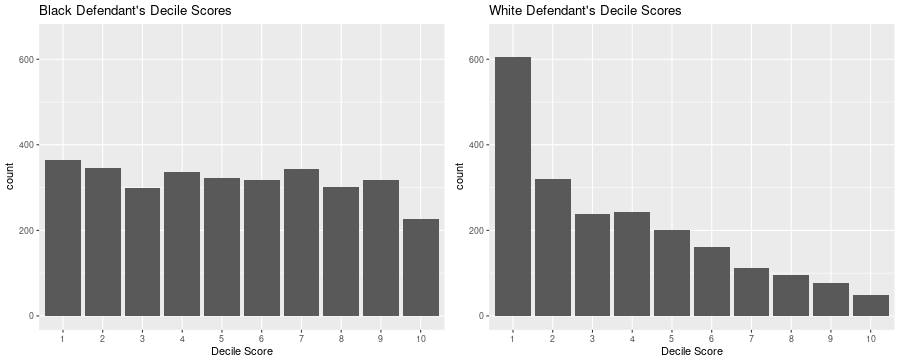

In [30]:
%%R -w 900 -h 363 -u px
library(grid)
library(gridExtra)
pblack <- ggplot(data=filter(df, race =="African-American"), aes(ordered(decile_score))) + 
          geom_bar() + xlab("Decile Score") +
          ylim(0, 650) + ggtitle("Black Defendant's Decile Scores")
pwhite <- ggplot(data=filter(df, race =="Caucasian"), aes(ordered(decile_score))) + 
          geom_bar() + xlab("Decile Score") +
          ylim(0, 650) + ggtitle("White Defendant's Decile Scores")
grid.arrange(pblack, pwhite,  ncol = 2)

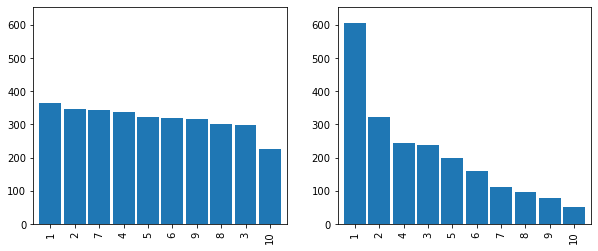

In [46]:
import matplotlib.pyplot as plt

# Set scaling on graph
max_dec_score = df[df['race'] == "African-American"]["decile_score"].value_counts().max()
max_dec_score = max(max_dec_score, df[df['race'] == "Caucasian"]["decile_score"].value_counts().max())
max_dec_score += 50

# Plot decile score for Black and White Defendants
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))
df[df['race'] == "African-American"]["decile_score"].value_counts().plot.bar(ax=ax1, ylim= (0,max_dec_score), width=.9)
df[df['race'] == "Caucasian"]["decile_score"].value_counts().plot.bar(ax=ax2, ylim = (0,max_dec_score), width=.9)

In [236]:
%%R
xtabs(~ decile_score + race, data=df)

            race
decile_score African-American Asian Caucasian Hispanic Native American Other
          1               365    15       605      159               0   142
          2               346     4       321       89               2    60
          3               298     5       238       73               1    32
          4               337     0       243       47               0    39
          5               323     1       200       39               0    19
          6               318     2       160       27               2    20
          7               343     1       113       28               2     9
          8               301     2        96       14               0     7
          9               317     0        77       17               2     7
          10              227     1        50       16               2     8


In [237]:
pd.crosstab(df["decile_score"], df["race"])

race,African-American,Asian,Caucasian,Hispanic,Native American,Other
decile_score,,,,,,
1,365,15,605,159,0,142
2,346,4,321,89,2,60
3,298,5,238,73,1,32
4,337,0,243,47,0,39
5,323,1,200,39,0,19
6,318,2,160,27,2,20
7,343,1,113,28,2,9
8,301,2,96,14,0,7
9,317,0,77,17,2,7


## Racial Bias in Compas

After filtering out bad rows, our first question is whether there is a significant difference in Compas scores between races. To do so we need to change some variables into factors, and run a logistic regression, comparing low scores to high scores.

In [238]:
%%R
df <- mutate(df, crime_factor = factor(c_charge_degree)) %>%
      mutate(age_factor = as.factor(age_cat)) %>%
      within(age_factor <- relevel(age_factor, ref = 1)) %>%
      mutate(race_factor = factor(race)) %>%
      within(race_factor <- relevel(race_factor, ref = 3)) %>%
      mutate(gender_factor = factor(sex, labels= c("Female","Male"))) %>%
      within(gender_factor <- relevel(gender_factor, ref = 2)) %>%
      mutate(score_factor = factor(score_text != "Low", labels = c("LowScore","HighScore")))
model <- glm(score_factor ~ gender_factor + age_factor + race_factor +
                            priors_count + crime_factor + two_year_recid, family="binomial", data=df)
summary(model)


Call:
glm(formula = score_factor ~ gender_factor + age_factor + race_factor + 
    priors_count + crime_factor + two_year_recid, family = "binomial", 
    data = df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.9966  -0.7919  -0.3303   0.8121   2.6024  

Coefficients:
                            Estimate Std. Error z value Pr(>|z|)    
(Intercept)                 -1.52554    0.07851 -19.430  < 2e-16 ***
gender_factorFemale          0.22127    0.07951   2.783 0.005388 ** 
age_factorGreater than 45   -1.35563    0.09908 -13.682  < 2e-16 ***
age_factorLess than 25       1.30839    0.07593  17.232  < 2e-16 ***
race_factorAfrican-American  0.47721    0.06935   6.881 5.93e-12 ***
race_factorAsian            -0.25441    0.47821  -0.532 0.594717    
race_factorHispanic         -0.42839    0.12813  -3.344 0.000827 ***
race_factorNative American   1.39421    0.76612   1.820 0.068784 .  
race_factorOther            -0.82635    0.16208  -5.098 3.43e-07 ***
priors_count  


Call:
glm(formula = score_factor ~ gender_factor + age_factor + race_factor + 
    priors_count + crime_factor + two_year_recid, family = "binomial", 
    data = df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.9966  -0.7919  -0.3303   0.8121   2.6024  

Coefficients:
                            Estimate Std. Error z value Pr(>|z|)    
(Intercept)                 -1.52554    0.07851 -19.430  < 2e-16 ***
gender_factorFemale          0.22127    0.07951   2.783 0.005388 ** 
age_factorGreater than 45   -1.35563    0.09908 -13.682  < 2e-16 ***
age_factorLess than 25       1.30839    0.07593  17.232  < 2e-16 ***
race_factorAfrican-American  0.47721    0.06935   6.881 5.93e-12 ***
race_factorAsian            -0.25441    0.47821  -0.532 0.594717    
race_factorHispanic         -0.42839    0.12813  -3.344 0.000827 ***
race_factorNative American   1.39421    0.76612   1.820 0.068784 .  
race_factorOther            -0.82635    0.16208  -5.098 3.43e-07 ***
priors_count  

Black defendants are 45% more likely than white defendants to receive a higher score correcting for the seriousness of their crime, previous arrests, and future criminal behavior.

In [17]:
%%R
control <- exp(-1.52554) / (1 + exp(-1.52554))
exp(0.47721) / (1 - control + (control * exp(0.47721)))

[1] 1.452841


Women are 19.4% more likely than men to get a higher score.

In [18]:
%%R
exp(0.22127) / (1 - control + (control * exp(0.22127)))

[1] 1.194798


Most surprisingly, people under 25 are 2.5 times as likely to get a higher score as middle aged defendants.

In [19]:
%%R
exp(1.30839) / (1 - control + (control * exp(1.30839)))

[1] 2.49612


### Risk of Violent Recidivism

Compas also offers a score that aims to measure a persons risk of violent recidivism, which has a similar overall accuracy to the Recidivism score. As before, we can use a logistic regression to test for racial bias.

In [20]:
%%R
raw_data <- read.csv("./compas-scores-two-years-violent.csv")
nrow(raw_data)

[1] 4743


In [21]:
%%R
df <- dplyr::select(raw_data, age, c_charge_degree, race, age_cat, v_score_text, sex, priors_count, 
                    days_b_screening_arrest, v_decile_score, is_recid, two_year_recid) %>% 
        filter(days_b_screening_arrest <= 30) %>%
        filter(days_b_screening_arrest >= -30) %>% 
        filter(is_recid != -1) %>%
        filter(c_charge_degree != "O") %>%
        filter(v_score_text != 'N/A')
nrow(df)

[1] 4020


In [22]:
%%R
summary(df$age_cat)

        25 - 45 Greater than 45    Less than 25 
           2300             954             766 


In [23]:
%%R
summary(df$race)

African-American            Asian        Caucasian         Hispanic 
            1918               26             1459              355 
 Native American            Other 
               7              255 


In [24]:
%%R
summary(df$v_score_text)

  High    Low Medium 
   279   2913    828 


In [25]:
%%R
nrow(filter(df, two_year_recid == 1)) / nrow(df) * 100

[1] 16.21891


In [26]:
%%R
nrow(filter(df, two_year_recid == 1))

[1] 652


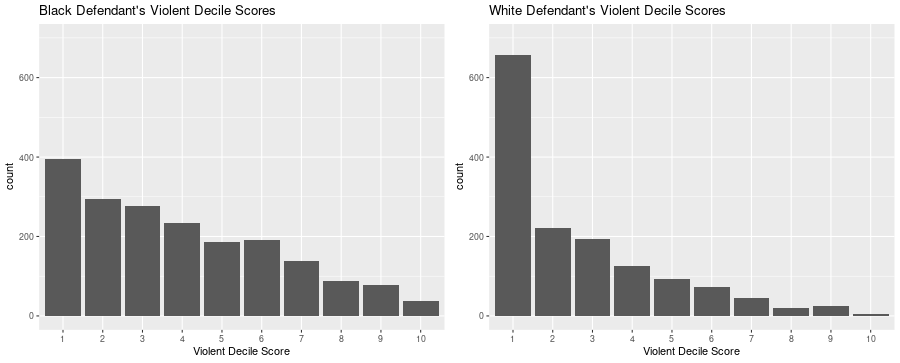

In [27]:
%%R -w 900 -h 363 -u px
library(grid)
library(gridExtra)
pblack <- ggplot(data=filter(df, race =="African-American"), aes(ordered(v_decile_score))) + 
          geom_bar() + xlab("Violent Decile Score") +
          ylim(0, 700) + ggtitle("Black Defendant's Violent Decile Scores")
pwhite <- ggplot(data=filter(df, race =="Caucasian"), aes(ordered(v_decile_score))) + 
          geom_bar() + xlab("Violent Decile Score") +
          ylim(0, 700) + ggtitle("White Defendant's Violent Decile Scores")
grid.arrange(pblack, pwhite,  ncol = 2)

In [28]:
%%R
df <- mutate(df, crime_factor = factor(c_charge_degree)) %>%
      mutate(age_factor = as.factor(age_cat)) %>%
      within(age_factor <- relevel(age_factor, ref = 1)) %>%
      mutate(race_factor = factor(race,
                                  labels = c("African-American", 
                                             "Asian",
                                             "Caucasian", 
                                             "Hispanic", 
                                             "Native American",
                                             "Other"))) %>%
      within(race_factor <- relevel(race_factor, ref = 3)) %>%
      mutate(gender_factor = factor(sex, labels= c("Female","Male"))) %>%
      within(gender_factor <- relevel(gender_factor, ref = 2)) %>%
      mutate(score_factor = factor(v_score_text != "Low", labels = c("LowScore","HighScore")))
model <- glm(score_factor ~ gender_factor + age_factor + race_factor +
                            priors_count + crime_factor + two_year_recid, family="binomial", data=df)
summary(model)


Call:
glm(formula = score_factor ~ gender_factor + age_factor + race_factor + 
    priors_count + crime_factor + two_year_recid, family = "binomial", 
    data = df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.9304  -0.5667  -0.3161   0.4192   2.8386  

Coefficients:
                            Estimate Std. Error z value Pr(>|z|)    
(Intercept)                 -2.24274    0.11326 -19.802  < 2e-16 ***
gender_factorFemale         -0.72890    0.12666  -5.755 8.66e-09 ***
age_factorGreater than 45   -1.74208    0.18415  -9.460  < 2e-16 ***
age_factorLess than 25       3.14591    0.11541  27.259  < 2e-16 ***
race_factorAfrican-American  0.65893    0.10815   6.093 1.11e-09 ***
race_factorAsian            -0.98521    0.70537  -1.397   0.1625    
race_factorHispanic         -0.06416    0.19133  -0.335   0.7374    
race_factorNative American   0.44793    1.03546   0.433   0.6653    
race_factorOther            -0.20543    0.22464  -0.914   0.3605    
priors_count  

The violent score overpredicts recidivism for black defendants by 77.3% compared to white defendants.

In [29]:
%%R
control <- exp(-2.24274) / (1 + exp(-2.24274))
exp(0.65893) / (1 - control + (control * exp(0.65893)))

[1] 1.773921


Defendands under 25 are 7.4 times as likely to get a higher score as middle aged defendants.

In [30]:
%%R
exp(3.14591) / (1 - control + (control * exp(3.14591)))

[1] 7.41424


## Predictive Accuracy of COMPAS

In order to test whether Compas scores do an accurate job of deciding whether an offender is Low, Medium or High risk,  we ran a Cox Proportional Hazards model. Northpointe, the company that created COMPAS and markets it to Law Enforcement, also ran a Cox model in their [validation study](http://cjb.sagepub.com/content/36/1/21.abstract).

We used the counting model and removed people when they were incarcerated. Due to errors in the underlying jail data, we need to filter out 32 rows that have an end date more than the start date. Considering that there are 13,334 total rows in the data, such a small amount of errors will not affect the results.

In [31]:
%%R
library(survival)
library(ggfortify)

data <- filter(filter(read.csv("./cox-parsed.csv"), score_text != "N/A"), end > start) %>%
        mutate(race_factor = factor(race,
                                  labels = c("African-American", 
                                             "Asian",
                                             "Caucasian", 
                                             "Hispanic", 
                                             "Native American",
                                             "Other"))) %>%
        within(race_factor <- relevel(race_factor, ref = 3)) %>%
        mutate(score_factor = factor(score_text)) %>%
        within(score_factor <- relevel(score_factor, ref=2))

grp <- data[!duplicated(data$id),]
nrow(grp)

R[write to console]: Error in library(ggfortify) : there is no package called ‘ggfortify’
Calls: <Anonymous> -> <Anonymous> -> withVisible -> library




Error in library(ggfortify) : there is no package called ‘ggfortify’
Calls: <Anonymous> -> <Anonymous> -> withVisible -> library


In [32]:
%%R
summary(grp$score_factor)

R[write to console]: Error in summary(grp$score_factor) : object 'grp' not found
Calls: <Anonymous> -> <Anonymous> -> withVisible -> summary




Error in summary(grp$score_factor) : object 'grp' not found
Calls: <Anonymous> -> <Anonymous> -> withVisible -> summary


In [33]:
%%R
summary(grp$race_factor)

R[write to console]: Error in summary(grp$race_factor) : object 'grp' not found
Calls: <Anonymous> -> <Anonymous> -> withVisible -> summary




Error in summary(grp$race_factor) : object 'grp' not found
Calls: <Anonymous> -> <Anonymous> -> withVisible -> summary


In [34]:
%%R
f <- Surv(start, end, event, type="counting") ~ score_factor
model <- coxph(f, data=data)
summary(model)

R[write to console]: Error in as.data.frame.default(data, optional = TRUE) : 
  cannot coerce class ‘"function"’ to a data.frame
Calls: <Anonymous> ... terms.formula -> as.data.frame -> as.data.frame.default




Error in as.data.frame.default(data, optional = TRUE) : 
  cannot coerce class ‘"function"’ to a data.frame
Calls: <Anonymous> ... terms.formula -> as.data.frame -> as.data.frame.default


People placed in the High category are 3.5 times as likely to recidivate, and the COMPAS system's concordance 63.6%. This is lower than the accuracy quoted in the Northpoint study of 68%.

In [35]:
%%R
decile_f <- Surv(start, end, event, type="counting") ~ decile_score
dmodel <- coxph(decile_f, data=data)
summary(dmodel)

R[write to console]: Error in as.data.frame.default(data, optional = TRUE) : 
  cannot coerce class ‘"function"’ to a data.frame
Calls: <Anonymous> ... terms.formula -> as.data.frame -> as.data.frame.default




Error in as.data.frame.default(data, optional = TRUE) : 
  cannot coerce class ‘"function"’ to a data.frame
Calls: <Anonymous> ... terms.formula -> as.data.frame -> as.data.frame.default


COMPAS's decile scores are a bit more accurate at 66%.

We can test if the algorithm is behaving differently across races by including a race interaction term in the cox model.

In [36]:
%%R
f2 <- Surv(start, end, event, type="counting") ~ race_factor + score_factor + race_factor * score_factor
model <- coxph(f2, data=data)
print(summary(model))

R[write to console]: Error in as.data.frame.default(data, optional = TRUE) : 
  cannot coerce class ‘"function"’ to a data.frame
Calls: <Anonymous> ... terms.formula -> as.data.frame -> as.data.frame.default




Error in as.data.frame.default(data, optional = TRUE) : 
  cannot coerce class ‘"function"’ to a data.frame
Calls: <Anonymous> ... terms.formula -> as.data.frame -> as.data.frame.default


The interaction term shows a similar disparity as the logistic regression above.

High risk white defendants are 3.61 more likely than low risk white defendants, while High risk black defendants are 2.99 more likely than low.

In [37]:
import math
print("Black High Hazard: %.2f" % (math.exp(-0.18976 + 1.28350)))
print("White High Hazard: %.2f" % (math.exp(1.28350)))
print("Black Medium Hazard: %.2f" % (math.exp(0.84286-0.17261)))
print("White Medium Hazard: %.2f" % (math.exp(0.84286)))

Black High Hazard: 2.99
White High Hazard: 3.61
Black Medium Hazard: 1.95
White Medium Hazard: 2.32


In [38]:
%%R -w 900 -h 563 -u px

fit <- survfit(f, data=data)

plotty <- function(fit, title) {
  return(autoplot(fit, conf.int=T, censor=F) + ggtitle(title) + ylim(0,1))
}
plotty(fit, "Overall")

R[write to console]: Error in as.data.frame.default(data, optional = TRUE) : 
  cannot coerce class ‘"function"’ to a data.frame
Calls: <Anonymous> ... terms.formula -> as.data.frame -> as.data.frame.default




Error in as.data.frame.default(data, optional = TRUE) : 
  cannot coerce class ‘"function"’ to a data.frame
Calls: <Anonymous> ... terms.formula -> as.data.frame -> as.data.frame.default


Black defendants do recidivate at higher rates according to race specific Kaplan Meier plots.

In [39]:
%%R -w 900 -h 363 -u px
white <- filter(data, race == "Caucasian")
white_fit <- survfit(f, data=white)

black <- filter(data, race == "African-American")
black_fit <- survfit(f, data=black)

grid.arrange(plotty(white_fit, "White defendants"), 
             plotty(black_fit, "Black defendants"), ncol=2)

R[write to console]: Error in UseMethod("filter_") : 
  no applicable method for 'filter_' applied to an object of class "function"
Calls: <Anonymous> ... <Anonymous> -> withVisible -> filter -> filter.default -> filter_




Error in UseMethod("filter_") : 
  no applicable method for 'filter_' applied to an object of class "function"
Calls: <Anonymous> ... <Anonymous> -> withVisible -> filter -> filter.default -> filter_


In [40]:
%%R
summary(fit, times=c(730))

R[write to console]: Error in summary(fit, times = c(730)) : object 'fit' not found
Calls: <Anonymous> -> <Anonymous> -> withVisible -> summary




Error in summary(fit, times = c(730)) : object 'fit' not found
Calls: <Anonymous> -> <Anonymous> -> withVisible -> summary


In [41]:
%%R
summary(black_fit, times=c(730))

R[write to console]: Error in summary(black_fit, times = c(730)) : 
  object 'black_fit' not found
Calls: <Anonymous> -> <Anonymous> -> withVisible -> summary




Error in summary(black_fit, times = c(730)) : 
  object 'black_fit' not found
Calls: <Anonymous> -> <Anonymous> -> withVisible -> summary


In [42]:
%%R
summary(white_fit, times=c(730))

R[write to console]: Error in summary(white_fit, times = c(730)) : 
  object 'white_fit' not found
Calls: <Anonymous> -> <Anonymous> -> withVisible -> summary




Error in summary(white_fit, times = c(730)) : 
  object 'white_fit' not found
Calls: <Anonymous> -> <Anonymous> -> withVisible -> summary


Race specific models have similar concordance values.

In [43]:
%%R
summary(coxph(f, data=white))

R[write to console]: Error in terms.formula(formula, specials = ss, data = data) : 
  object 'white' not found
Calls: <Anonymous> ... withVisible -> summary -> coxph -> terms -> terms.formula




Error in terms.formula(formula, specials = ss, data = data) : 
  object 'white' not found
Calls: <Anonymous> ... withVisible -> summary -> coxph -> terms -> terms.formula


In [44]:
%%R
summary(coxph(f, data=black))

R[write to console]: Error in terms.formula(formula, specials = ss, data = data) : 
  object 'black' not found
Calls: <Anonymous> ... withVisible -> summary -> coxph -> terms -> terms.formula




Error in terms.formula(formula, specials = ss, data = data) : 
  object 'black' not found
Calls: <Anonymous> ... withVisible -> summary -> coxph -> terms -> terms.formula


Compas's violent recidivism score has a slightly higher overall concordance score of 65.1%.

In [45]:
%%R
violent_data <- filter(filter(read.csv("./cox-violent-parsed.csv"), score_text != "N/A"), end > start) %>%
        mutate(race_factor = factor(race,
                                  labels = c("African-American", 
                                             "Asian",
                                             "Caucasian", 
                                             "Hispanic", 
                                             "Native American",
                                             "Other"))) %>%
        within(race_factor <- relevel(race_factor, ref = 3)) %>%
        mutate(score_factor = factor(score_text)) %>%
        within(score_factor <- relevel(score_factor, ref=2))


vf <- Surv(start, end, event, type="counting") ~ score_factor
vmodel <- coxph(vf, data=violent_data)
vgrp <- violent_data[!duplicated(violent_data$id),]
print(nrow(vgrp))
summary(vmodel)

[1] 10985
Call:
coxph(formula = vf, data = violent_data)

  n= 18178, number of events= 818 

                      coef exp(coef) se(coef)      z Pr(>|z|)    
score_factorHigh   1.38311   3.98729  0.08410 16.447   <2e-16 ***
score_factorMedium 0.80350   2.23334  0.08699  9.236   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                   exp(coef) exp(-coef) lower .95 upper .95
score_factorHigh       3.987     0.2508     3.381     4.702
score_factorMedium     2.233     0.4478     1.883     2.649

Concordance= 0.651  (se = 0.009 )
Likelihood ratio test= 270.6  on 2 df,   p=<2e-16
Wald test            = 272.2  on 2 df,   p=<2e-16
Score (logrank) test = 307.9  on 2 df,   p=<2e-16



In this case, there isn't a significant coefficient on African American's with High Scores.

In [46]:
%%R
vf2 <- Surv(start, end, event, type="counting") ~ race_factor + race_factor * score_factor
vmodel <- coxph(vf2, data=violent_data)
summary(vmodel)

Call:
coxph(formula = vf2, data = violent_data)

  n= 18178, number of events= 818 

                                                     coef  exp(coef)   se(coef)
race_factorAfrican-American                     1.976e-01  1.219e+00  1.321e-01
race_factorAsian                               -5.838e-01  5.577e-01  1.005e+00
race_factorHispanic                            -1.754e-01  8.391e-01  2.150e-01
race_factorNative American                     -1.304e+01  2.162e-06  7.607e+02
race_factorOther                               -4.459e-02  9.564e-01  2.433e-01
score_factorHigh                                1.250e+00  3.491e+00  1.720e-01
score_factorMedium                              6.292e-01  1.876e+00  1.583e-01
race_factorAfrican-American:score_factorHigh   -7.627e-03  9.924e-01  2.063e-01
race_factorAsian:score_factorHigh               1.552e+00  4.721e+00  1.425e+00
race_factorHispanic:score_factorHigh            1.606e-01  1.174e+00  3.969e-01
race_factorNative American:score_fa

In [47]:
%%R
summary(coxph(vf, data=filter(violent_data, race == "African-American")))

Call:
coxph(formula = vf, data = filter(violent_data, race == "African-American"))

  n= 9712, number of events= 495 

                     coef exp(coef) se(coef)      z Pr(>|z|)    
score_factorHigh   1.2412    3.4596   0.1140 10.891  < 2e-16 ***
score_factorMedium 0.7589    2.1359   0.1202  6.315 2.71e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                   exp(coef) exp(-coef) lower .95 upper .95
score_factorHigh       3.460     0.2891     2.767     4.325
score_factorMedium     2.136     0.4682     1.688     2.703

Concordance= 0.638  (se = 0.012 )
Likelihood ratio test= 127.5  on 2 df,   p=<2e-16
Wald test            = 118.7  on 2 df,   p=<2e-16
Score (logrank) test = 130.9  on 2 df,   p=<2e-16



In [48]:
%%R
summary(coxph(vf, data=filter(violent_data, race == "Caucasian")))

Call:
coxph(formula = vf, data = filter(violent_data, race == "Caucasian"))

  n= 6041, number of events= 221 

                     coef exp(coef) se(coef)     z Pr(>|z|)    
score_factorHigh   1.2502    3.4909   0.1720 7.267 3.67e-13 ***
score_factorMedium 0.6310    1.8794   0.1583 3.986 6.71e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                   exp(coef) exp(-coef) lower .95 upper .95
score_factorHigh       3.491     0.2865     2.492     4.891
score_factorMedium     1.879     0.5321     1.378     2.563

Concordance= 0.61  (se = 0.018 )
Likelihood ratio test= 49.63  on 2 df,   p=2e-11
Wald test            = 55.48  on 2 df,   p=9e-13
Score (logrank) test = 61.24  on 2 df,   p=5e-14



In [49]:
%%R -w 900 -h 363 -u px
white <- filter(violent_data, race == "Caucasian")
white_fit <- survfit(vf, data=white)

black <- filter(violent_data, race == "African-American")
black_fit <- survfit(vf, data=black)

grid.arrange(plotty(white_fit, "White defendants"), 
             plotty(black_fit, "Black defendants"), ncol=2)

R[write to console]: Error in plotty(white_fit, "White defendants") : 
  could not find function "plotty"
Calls: <Anonymous> ... <Anonymous> -> withVisible -> grid.arrange -> arrangeGrob

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In fitter(X, Y, istrat, offset, init, control, weights = weights,  :
R[write to console]: 
 
R[write to console]:  Loglik converged before variable  4,11,16 ; beta may be infinite. 




Error in plotty(white_fit, "White defendants") : 
  could not find function "plotty"
Calls: <Anonymous> ... <Anonymous> -> withVisible -> grid.arrange -> arrangeGrob


## Directions of the Racial Bias

The above analysis shows that the Compas algorithm does overpredict African-American defendant's future recidivism, but we haven't yet explored the direction of the bias. We can discover fine differences in overprediction and underprediction by comparing Compas scores across racial lines.

In [50]:
from truth_tables import PeekyReader, Person, table, is_race, count, vtable, hightable, vhightable
from csv import DictReader

people = []
with open("./cox-parsed.csv") as f:
    reader = PeekyReader(DictReader(f))
    try:
        while True:
            p = Person(reader)
            if p.valid:
                people.append(p)
    except StopIteration:
        pass

pop = list(filter(lambda i: ((i.recidivist == True and i.lifetime <= 730) or
                              i.lifetime > 730), list(filter(lambda x: x.score_valid, people))))
recid = list(filter(lambda i: i.recidivist == True and i.lifetime <= 730, pop))
rset = set(recid)
surv = [i for i in pop if i not in rset]

In [51]:
print("All defendants")
table(list(recid), list(surv))

All defendants
           	Low	High
Survived   	2681	1282	0.55
Recidivated	1216	2035	0.45
Total: 7214.00
False positive rate: 32.35
False negative rate: 37.40
Specificity: 0.68
Sensitivity: 0.63
Prevalence: 0.45
PPV: 0.61
NPV: 0.69
LR+: 1.94
LR-: 0.55


In [52]:
print("Total pop: %i" % (2681 + 1282 + 1216 + 2035))

Total pop: 7214


In [53]:
import statistics
print("Average followup time %.2f (sd %.2f)" % (statistics.mean(map(lambda i: i.lifetime, pop)),
                                                statistics.stdev(map(lambda i: i.lifetime, pop))))
print("Median followup time %i" % (statistics.median(map(lambda i: i.lifetime, pop))))

Average followup time 622.87 (sd 392.19)
Median followup time 766


Overall, the false positive rate is 32.35%.

In [54]:
print("Black defendants")
is_afam = is_race("African-American")
table(list(filter(is_afam, recid)), list(filter(is_afam, surv)))

Black defendants
           	Low	High
Survived   	990	805	0.49
Recidivated	532	1369	0.51
Total: 3696.00
False positive rate: 44.85
False negative rate: 27.99
Specificity: 0.55
Sensitivity: 0.72
Prevalence: 0.51
PPV: 0.63
NPV: 0.65
LR+: 1.61
LR-: 0.51


That number is higher for African Americans at 44.85%.

In [55]:
print("White defendants")
is_white = is_race("Caucasian")
table(list(filter(is_white, recid)), list(filter(is_white, surv)))

White defendants
           	Low	High
Survived   	1139	349	0.61
Recidivated	461	505	0.39
Total: 2454.00
False positive rate: 23.45
False negative rate: 47.72
Specificity: 0.77
Sensitivity: 0.52
Prevalence: 0.39
PPV: 0.59
NPV: 0.71
LR+: 2.23
LR-: 0.62


And lower for whites at 23.45%.

In [56]:
44.85 / 23.45

1.9125799573560769

Which means under COMPAS black defendants are 91% more likely to get a higher score and not go on to commit more crimes than white defendants after two year.

COMPAS scores misclassify white reoffenders as low risk at 70.4% more often than black reoffenders.

In [57]:
47.72 / 27.99

1.7048946052161487

In [58]:
hightable(list(filter(is_white, recid)), list(filter(is_white, surv)))

           	Low	High
Survived   	1407	81	0.61
Recidivated	771	195	0.39
Total: 2454.00
False positive rate: 5.44
False negative rate: 79.81
Specificity: 0.95
Sensitivity: 0.20
Prevalence: 0.39
PPV: 0.71
NPV: 0.65
LR+: 3.71
LR-: 0.84


In [59]:
hightable(list(filter(is_afam, recid)), list(filter(is_afam, surv)))

           	Low	High
Survived   	1511	284	0.49
Recidivated	1160	741	0.51
Total: 3696.00
False positive rate: 15.82
False negative rate: 61.02
Specificity: 0.84
Sensitivity: 0.39
Prevalence: 0.51
PPV: 0.72
NPV: 0.57
LR+: 2.46
LR-: 0.72


## Risk of Violent Recidivism

Compas also offers a score that aims to measure a persons risk of violent recidivism, which has a similar overall accuracy to the Recidivism score.

In [60]:
vpeople = []
with open("./cox-violent-parsed.csv") as f:
    reader = PeekyReader(DictReader(f))
    try:
        while True:
            p = Person(reader)
            if p.valid:
                vpeople.append(p)
    except StopIteration:
        pass

vpop = list(filter(lambda i: ((i.violent_recidivist == True and i.lifetime <= 730) or
                              i.lifetime > 730), list(filter(lambda x: x.vscore_valid, vpeople))))
vrecid = list(filter(lambda i: i.violent_recidivist == True and i.lifetime <= 730, vpeople))
vrset = set(vrecid)
vsurv = [i for i in vpop if i not in vrset]

In [61]:
print("All defendants")
vtable(list(vrecid), list(vsurv))

All defendants
           	Low	High
Survived   	4121	1597	0.89
Recidivated	347	389	0.11
Total: 6454.00
False positive rate: 27.93
False negative rate: 47.15
Specificity: 0.72
Sensitivity: 0.53
Prevalence: 0.11
PPV: 0.20
NPV: 0.92
LR+: 1.89
LR-: 0.65


Even moreso for Black defendants.

In [62]:
print("Black defendants")
is_afam = is_race("African-American")
vtable(list(filter(is_afam, vrecid)), list(filter(is_afam, vsurv)))

Black defendants
           	Low	High
Survived   	1692	1043	0.86
Recidivated	170	273	0.14
Total: 3178.00
False positive rate: 38.14
False negative rate: 38.37
Specificity: 0.62
Sensitivity: 0.62
Prevalence: 0.14
PPV: 0.21
NPV: 0.91
LR+: 1.62
LR-: 0.62


In [63]:
print("White defendants")
is_white = is_race("Caucasian")
vtable(list(filter(is_white, vrecid)), list(filter(is_white, vsurv)))

White defendants
           	Low	High
Survived   	1679	380	0.91
Recidivated	129	77	0.09
Total: 2265.00
False positive rate: 18.46
False negative rate: 62.62
Specificity: 0.82
Sensitivity: 0.37
Prevalence: 0.09
PPV: 0.17
NPV: 0.93
LR+: 2.03
LR-: 0.77


Black defendants are twice as likely to be false positives for a Higher violent score than white defendants.

In [64]:
38.14 / 18.46

2.066088840736728

White defendants are 63% more likely to get a lower score and commit another crime than Black defendants.

In [65]:
62.62 / 38.37

1.63200416992442

## Gender differences in Compas scores

In terms of underlying recidivism rates, we can look at gender specific Kaplan Meier estimates. There is a striking difference between women and men.

In [66]:
%%R

female <- filter(data, sex == "Female")
male   <- filter(data, sex == "Male")
male_fit <- survfit(f, data=male)
female_fit <- survfit(f, data=female)

R[write to console]: Error in UseMethod("filter_") : 
  no applicable method for 'filter_' applied to an object of class "function"
Calls: <Anonymous> ... <Anonymous> -> withVisible -> filter -> filter.default -> filter_




Error in UseMethod("filter_") : 
  no applicable method for 'filter_' applied to an object of class "function"
Calls: <Anonymous> ... <Anonymous> -> withVisible -> filter -> filter.default -> filter_


In [67]:
%%R
summary(male_fit, times=c(730))

R[write to console]: Error in summary(male_fit, times = c(730)) : object 'male_fit' not found
Calls: <Anonymous> -> <Anonymous> -> withVisible -> summary




Error in summary(male_fit, times = c(730)) : object 'male_fit' not found
Calls: <Anonymous> -> <Anonymous> -> withVisible -> summary


In [68]:
%%R
summary(female_fit, times=c(730))

R[write to console]: Error in summary(female_fit, times = c(730)) : 
  object 'female_fit' not found
Calls: <Anonymous> -> <Anonymous> -> withVisible -> summary




Error in summary(female_fit, times = c(730)) : 
  object 'female_fit' not found
Calls: <Anonymous> -> <Anonymous> -> withVisible -> summary


In [69]:
%%R -w 900 -h 363 -u px
grid.arrange(plotty(female_fit, "Female"), plotty(male_fit, "Male"),ncol=2)

R[write to console]: Error in plotty(female_fit, "Female") : could not find function "plotty"
Calls: <Anonymous> ... <Anonymous> -> withVisible -> grid.arrange -> arrangeGrob




Error in plotty(female_fit, "Female") : could not find function "plotty"
Calls: <Anonymous> ... <Anonymous> -> withVisible -> grid.arrange -> arrangeGrob


As these plots show, the Compas score treats a High risk women the same as a Medium risk man.